# Machine Learning using Sentinel-2 Data

This example uses training data from the
[Coast Train](https://github.com/nick-murray/coastTrain) dataset
along with Sentinel-2 data to demonstrate how to use a
machine learning classifier, in this case, Random Forest, to
assign a class to each pixel.

This notebook combines lessons from previous notebooks into
a comprehensive worked example.

## Getting started

First we load the required Python libraries and tools.

In [25]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
# from ipyleaflet import basemaps

from sklearn.ensemble import RandomForestClassifier
import sys
sys.path.append("../..")
from ldn.utils import typology_mapping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


## Training data

Load it.

In [ ]:
# Get the training data
training_data = gpd.read_file("training_data_geomad_dem.geojson")

class_attr = "lulc"
colours = typology_mapping["colours"]

sys.path.append("../../")

training_data.explore(
    column=class_attr,
    categorical=True,
    categories=(present_classes := sorted(training_data[class_attr].unique())),
    cmap=[colours[c] for c in present_classes],
    legend=True,
    style_kwds={"radius": 6, "fillOpacity": 0.8, "weight": 0.5}
)

In [27]:
# Remove geometry column for train/test split
training_data = training_data.drop(columns="geometry")

# Split 70/30 into train/test. Splits the classes into train/test in a representative way.
train_gdf, test_gdf = train_test_split(training_data, test_size=0.3, stratify=training_data[class_attr], random_state=42)

print(f"Training set class distribution:\n{train_gdf[class_attr].value_counts()}")
print(f"Test set class distribution:\n{test_gdf[class_attr].value_counts()}")
print(train_gdf)

Training set class distribution:
lulc
7    465
5    168
2     53
6     53
3     52
4     52
1     52
Name: count, dtype: int64
Test set class distribution:
lulc
7    199
5     72
3     23
1     23
4     23
6     22
2     22
Name: count, dtype: int64
      lulc     nir08       red    swir22        emad      smad    swir16  \
178      7  0.008918  0.012603  0.017718  1113.88760  0.000998  0.019697   
1017     2  0.256748  0.071233  0.096753  2082.08300  0.000587  0.183872   
699      5  0.232410  0.117515  0.183762  2079.72220  0.000840  0.238102   
279      7  0.005177  0.011997  0.012245  1026.11560  0.000641  0.012410   
495      7  0.005012  0.002785  0.014857   963.71686  0.001050  0.015875   
...    ...       ...       ...       ...         ...       ...       ...   
1191     4  0.304212  0.030945  0.051790  2317.11230  0.000761  0.128213   
266      7  0.013152  0.009440  0.016342  1675.87520  0.001771  0.019422   
591      7  0.003363  0.007928  0.012520  1165.37920  0.000837  0.

## Create a classifier and fit a model

We pass in simple numpy arrays to the classifier, one has the
observations (the values of the red, green, blue and so on)
while the other has the classes.

In [28]:
# The classes are the first column
classes = np.array(train_gdf)[:, 0]
print(f"Classes: {classes}")

# The observation data is everything after the first column
observations = np.array(train_gdf)[:, 1:]

# Create a model...
classifier = RandomForestClassifier(class_weight='balanced')

# ...and fit it to the data
model = classifier.fit(observations, classes)

Classes: [7. 2. 5. 7. 7. 7. 5. 7. 7. 7. 7. 2. 7. 3. 7. 7. 2. 4. 5. 7. 7. 7. 7. 1.
 5. 7. 7. 5. 7. 1. 7. 7. 6. 7. 4. 7. 7. 5. 5. 5. 7. 7. 7. 4. 7. 4. 6. 1.
 7. 3. 7. 7. 7. 7. 6. 5. 5. 5. 5. 7. 1. 4. 7. 4. 7. 6. 7. 2. 5. 6. 6. 7.
 5. 3. 7. 7. 7. 5. 5. 5. 7. 5. 2. 7. 7. 7. 4. 7. 7. 7. 2. 7. 7. 5. 7. 7.
 5. 2. 7. 7. 7. 2. 7. 6. 3. 5. 2. 1. 6. 7. 6. 7. 5. 1. 7. 5. 3. 3. 7. 2.
 7. 7. 7. 7. 5. 7. 1. 3. 7. 7. 2. 5. 7. 5. 1. 2. 6. 7. 7. 7. 5. 7. 7. 7.
 7. 3. 4. 5. 5. 7. 7. 7. 7. 7. 6. 7. 7. 5. 3. 2. 5. 7. 7. 5. 1. 7. 7. 7.
 7. 7. 7. 7. 5. 5. 7. 4. 7. 3. 1. 7. 6. 6. 5. 7. 7. 5. 7. 6. 7. 7. 7. 7.
 5. 2. 7. 5. 4. 7. 7. 5. 3. 2. 7. 7. 1. 6. 7. 7. 4. 7. 3. 5. 5. 5. 6. 2.
 5. 6. 7. 7. 5. 7. 1. 5. 2. 7. 5. 7. 5. 5. 7. 3. 7. 1. 3. 7. 7. 3. 1. 7.
 4. 5. 7. 4. 1. 7. 7. 7. 1. 5. 7. 5. 7. 2. 7. 7. 5. 5. 5. 5. 7. 7. 7. 5.
 5. 2. 7. 7. 7. 7. 1. 7. 7. 7. 3. 5. 4. 5. 7. 2. 6. 6. 7. 2. 2. 4. 6. 7.
 7. 5. 7. 7. 7. 5. 4. 7. 1. 5. 7. 7. 7. 7. 3. 5. 7. 5. 7. 7. 7. 3. 5. 4.
 5. 7. 7. 5. 7. 6. 7. 5. 2. 7. 1. 7. 5. 3.

In [29]:
# Define features and target

feature_cols = [c for c in train_gdf.columns if c != class_attr]

X_train = train_gdf[feature_cols].values
y_train = train_gdf[class_attr].values

X_test = test_gdf[feature_cols].values
y_test = test_gdf[class_attr].values

# Train
classifier = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model = classifier.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

target_names = [k for k, v in sorted(typology_mapping["classes"].items(), key=lambda x: x[1]) if v != 0]

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Tree Cover       0.46      0.52      0.49        23
   Grassland       0.44      0.50      0.47        22
    Cropland       0.40      0.17      0.24        23
     Wetland       0.89      0.70      0.78        23
    Built-up       0.60      0.86      0.71        72
       Other       0.20      0.09      0.12        22
       Water       0.99      0.95      0.97       199

    accuracy                           0.77       384
   macro avg       0.57      0.54      0.54       384
weighted avg       0.77      0.77      0.76       384



In [ ]:
# geomad_dem=xr.open_dataset('geomad_dem.tif',engine="rasterio").astype(np.uint8).to_array().squeeze()
geomad_dem = xr.open_dataset("geomad_dem.nc")

stack = np.stack([geomad_dem[f].values.flatten() for f in feature_cols], axis=1)

# Replace NaN and inf with 0
stack = np.nan_to_num(stack, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

predictions = model.predict(stack)

# Reshape back to raster
prediction_map = predictions.reshape(geomad_dem[feature_cols[0]].shape)

# Wrap in DataArray
predicted_da = xr.DataArray(
    prediction_map,
    coords={"y": geomad_dem.y, "x": geomad_dem.x},
    dims=["y", "x"],
    name="lulc",
)

## Visualise our results


In [ ]:
from matplotlib.colors import ListedColormap

present_classes = sorted(np.unique(predicted_da.values).tolist())
cmap = ListedColormap([colours[c] for c in present_classes])

predicted_da.odc.explore(cmap=cmap, legend=True)

              precision    recall  f1-score   support

  Tree Cover       0.46      0.52      0.49        23
   Grassland       0.44      0.50      0.47        22
    Cropland       0.40      0.17      0.24        23
     Wetland       0.89      0.70      0.78        23
    Built-up       0.60      0.86      0.71        72
       Other       0.20      0.09      0.12        22
       Water       0.99      0.95      0.97       199

    accuracy                           0.77       384
   macro avg       0.57      0.54      0.54       384
weighted avg       0.77      0.77      0.76       384



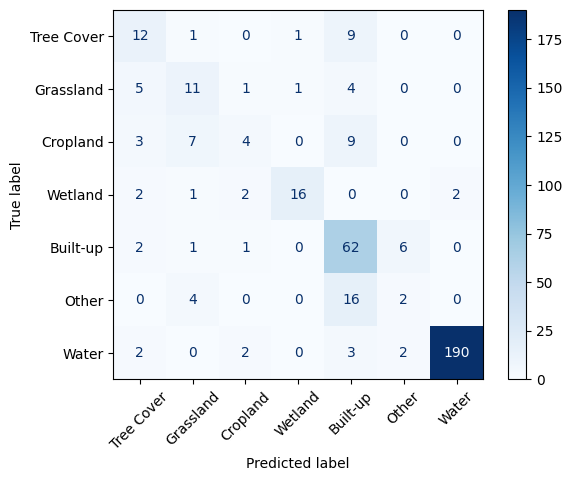

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

target_names = [k for k, v in sorted(typology_mapping["classes"].items(), key=lambda x: x[1]) if v != 0]

# Classification report
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45, cmap="Blues")